In [ ]:
### google drive 연결
from google.colab import drive
import os

drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/test')
print(os.listdir(os.getcwd()))

# google drive 연결해제
# drive.flush_and_unmount()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['keras_v0.1.ipynb', 'kaggle.json', 'input', 'temp', 'model']


In [ ]:
### 저장된 kaggle.json 파일을 코랩에 업로드
import os
from google.colab import files

if not os.path.exists('./input/'):
    os.mkdir('./input/')
if not os.path.exists('./temp/'):
    os.mkdir('./temp/')
if not os.path.exists('./model/'):
    os.mkdir('./model/')

# 1.파일 선택 버튼 클릭 후 kaggle.json 파일 업로드
if 'kaggle.json' not in os.listdir('.'):
    files.upload()

# 2.kaggle.json 파일의 위치 변경
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# 3.잘 저장 되었는지 한번 확인
!ls -1ha kaggle.json

# 4. Kaggle Download (예시)
print('Kaggle 데이터 다운로드 합니다.')
os.chdir('./input/')
filename = 'rupakroy/lstm-datasets-multivariate-univariate'
# filename = 'vincenttu/catfacesdatasetfferlito'
!kaggle datasets download -d $filename

# 5. 만약 다운받은 데이터가 압축파일일 경우
try:
    !unzip -o *.zip    # zip 파일 압축해제
    !rm -rf *.zip
    !tar -xvf -o *.tar    # tar 파일 압축해제
    !tar -zxvf -o *.tar.gz    # tar.gz 파일 압축해제
except:
    pass

os.chdir('..')
!pwd

kaggle.json
Kaggle 데이터 다운로드 합니다.
  0% 0.00/444k [00:00<?, ?B/s]
100% 444k/444k [00:00<00:00, 41.1MB/s]
Archive:  lstm-datasets-multivariate-univariate.zip
  inflating: LSTM-Multivariate_pollution.csv  
  inflating: pollution_test_data1.csv  
tar: -o: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now
tar (child): -o: Cannot open: No such file or directory
tar (child): Error is not recoverable: exiting now
tar: Child returned status 2
tar: Error is not recoverable: exiting now
/content/drive/MyDrive/working/2. Machine Learning AI/keras/test


In [ ]:
!pip list | grep tensorflow
!pip list | grep keras

tensorflow                       2.15.0
tensorflow-datasets              4.9.4
tensorflow-estimator             2.15.0
tensorflow-gcs-config            2.15.0
tensorflow-hub                   0.16.1
tensorflow-io-gcs-filesystem     0.36.0
tensorflow-metadata              1.14.0
tensorflow-probability           0.23.0
keras                            2.15.0
tf-keras                         2.15.0


In [ ]:
# 1. Input 생성하고 DNN에 적용 (예시: LSTM)
# - make_dataset()
# - window size를 np array 넣어서 3D array로 만들어야됌

# 2. Input 생성하고 Scikit-Learn과 Tensorflow.estimator 모델에 적용 (XGBoost)
# - 그대로 Pandas DataFrame을 Input으로 넣을 수 있음

In [ ]:
import pandas as pd

df = pd.read_csv('./input/LSTM-Multivariate_pollution.csv')
display(df.head(3))

print(min(df['date']), '~', max(df['date']))

,date,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
0,2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
1,2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2,2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0


2010-01-02 00:00:00 ~ 2014-12-31 23:00:00


In [ ]:
import datetime

# ================================================================================================================================
# 사용자 설정
# --------------------------------------------------------------------------------------------------------------------------------
dict_args = dict()
# --------------------------------------------------------------------------------------------------------------------------------
# 입력 관련 설정
# --------------------------------------------------------------------------------------------------------------------------------
dict_args['base_file'] = './input/LSTM-Multivariate_pollution.csv'
# 기준일자
dict_args['date_col_name'] = 'date'
# 타겟컬럼
dict_args['target_col_name'] = 'pollution'
# 피쳐컬럼
dict_args['feature_col_name'] = ['pollution','dew','temp','press','wnd_dir','wnd_spd','snow','rain']
# 학습 구간 (window size)
dict_args['window_size'] = 1
# 테스트 시작 기간
dict_args['test_date_start'] = '20141201000000'
# 테스트 종료 기간
dict_args['test_date_finish'] = '20141231230000'

test_date_start = datetime.datetime.strptime(dict_args['test_date_start'], '%Y%m%d%H%M%S')
test_date_finish = datetime.datetime.strptime(dict_args['test_date_finish'], '%Y%m%d%H%M%S')

# 테스트 크기
# dict_args['test_size'] = (test_date_finish - test_date_start).days * 24
dict_args['test_size'] = 12

# 모델 파일 저장 패턴
dict_args['model_file'] = './model/test_model_00000.h5'

dict_args['LabelEncodingColumn'] = [4]
dict_args['Norm'] = True

dict_args

{'base_file': './input/LSTM-Multivariate_pollution.csv',
 'date_col_name': 'date',
 'target_col_name': 'pollution',
 'feature_col_name': ['pollution',
  'dew',
  'temp',
  'press',
  'wnd_dir',
  'wnd_spd',
  'snow',
  'rain'],
 'window_size': 1,
 'test_date_start': '20141201000000',
 'test_date_finish': '20141231230000',
 'test_size': 12,
 'model_file': './model/test_model_00000.h5',
 'LabelEncodingColumn': [4],
 'Norm': True}

In [ ]:
# window 기간에 과거 데이터를 통한 예측 데이터 생성 함수
def make_dataset(data, label, window_size):
    import numpy as np
    feature_list = list()
    label_list = list()
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

def split_data(DataFrame, p_args):
    import pandas as pd
    # train_test 분리
    DataFrame['date'] = DataFrame.index
    train = DataFrame[DataFrame['date'] < p_args['predict_date']]
    test = DataFrame[DataFrame['date'] >= p_args['predict_date']]
    train = train.set_index('date')
    test = test.set_index('date')

    # feature, target 분리
    train_feature = train[p_args['feature_col_name']]    # train_X
    train_label = pd.DataFrame(train[p_args['target_col_name']])    # train_y
    test_feature = test[p_args['feature_col_name']]    # test_X
    test_label = pd.DataFrame(test[p_args['target_col_name']])    # test_y

    # Dataframe 형태로 csv 파일 저장
    train_feature.to_csv('./temp/' + 'X_train.csv', index=None, encoding='utf-8-sig')
    train_label.to_csv('./temp/' + 'y_train.csv', index=None, encoding='utf-8-sig')
    test_feature.to_csv('./temp/' + 'X_test.csv', index=None, encoding='utf-8-sig')
    test_label.to_csv('./temp/' + 'y_test.csv', index=None, encoding='utf-8-sig')

    # 예측 주기에 따른 timestep 생성
    print('DataFrame을 3D numpy로 변환 합니다.')
    train_feature, train_label = make_dataset(train_feature, train_label, p_args['window_size'])
    test_feature, test_label = make_dataset(test_feature, test_label, p_args['window_size'])
    print(train_feature.shape, train_label.shape, test_feature.shape, test_label.shape)
    # print(train_feature[:3])
    # print(train_label[:3])

    return train_feature, train_label, test_feature, test_label

def LSTM_MODEL(train_feature, train_label, test_feature, test_label, valid_ratio):
    from sklearn.model_selection import train_test_split
    from keras.models import Sequential
    from keras.layers import Dense
    from keras.layers import LSTM
    from keras.callbacks import EarlyStopping, ModelCheckpoint
    import keras
    import pandas as pd


    # train_valid 분할
    X_train, X_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=valid_ratio)

    # Sequential 모델 레이어 생성
    model = Sequential()
    model.add(LSTM(15,input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1))

     # 모델 컴파일 활성함수 loss_function 지정 , 최적화함수 지정
    model.compile(loss='mae', metrics=['accuracy'], optimizer='adam')

    # 얼리스탑핑 ( val_loss의 변화를 비교, 같은 값 5번 일시 중지)
    early_stop = EarlyStopping(monitor='val_loss', patience=20, baseline=0.4, mode ='min')
    # 모형 가중치 저장 파일 경로 선언
    # 모형 가중치 판단 및 모델 저장
    filename = 'model/model_checkpoint.h5'
    checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

    # 모형 학습
    model.fit(X_train, y_train,
                epochs=1,
                batch_size=16,
                verbose = 0,
                validation_data=(X_valid, y_valid),
                callbacks=[early_stop, checkpoint],
                shuffle=False
             )

    return model, filename


# Label Encoding for Categorical Variable
def label_encoding(df, p_args):
    from sklearn.preprocessing import LabelEncoder
    if p_args['LabelEncodingColumn'] != '':
        print('Label Encoding을 합니다.')
        encoder = LabelEncoder()
        encoding_list = p_args['LabelEncodingColumn']
        for i in range(len(encoding_list)):
            df.iloc[:, encoding_list[i]] = encoder.fit_transform(df.iloc[:, encoding_list[i]])
    return df

# Normalization (Min-Max Scaling)
def normalization(df, p_args):
    from sklearn.preprocessing import MinMaxScaler
    if p_args['Norm']:
        scaler = MinMaxScaler()
        print('Min-Max Scaling을 합니다.')
        scaled_df = scaler.fit_transform(df)
        df = pd.DataFrame(scaled_df, index = df.index, columns = df.columns)
        # 결과 파일 저장
        df.to_csv('./temp/' + 'normalized_df.csv', index=None, encoding='utf-8-sig')
    return df, scaler


import warnings
import sklearn
import sklearn.model_selection
import tensorflow.keras.models
import tensorflow.keras.layers
import tensorflow.keras.callbacks
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

df_source = pd.read_csv(dict_args['base_file'])
df_source = df_source.set_index('date')
df_normalized = df_source.copy()
df_normalized = df_normalized.fillna(1 + 1e-7)
df_normalized = label_encoding(df_normalized, dict_args)    # Categorical Variable Encoding
df_normalized, scaler = normalization(df_normalized, dict_args)    # Min-Max Scaling
print('df_normalized: ', df_normalized.shape)
# display(df_normalized)

list_predict = list()
for idx in tqdm(range(dict_args['test_size'])):
    # print('-'*150)
    df_train_sub = df_normalized.tail(dict_args['window_size'] + idx + 1).head(dict_args['window_size'])
    predict_date = df_train_sub.tail(1).index.tolist()[0]
    dict_args['predict_date'] = predict_date
    print('predict_date: ', predict_date)
    X_train, y_train, X_test, y_test = split_data(df_normalized, dict_args)

    model_instance, filename = LSTM_MODEL(X_train, y_train,  X_test, y_test, valid_ratio=0.2)
    model_instance.fit(X_train, y_train)

Label Encoding을 합니다.
Min-Max Scaling을 합니다.
df_normalized:  (43800, 8)


  0%|          | 0/12 [00:00<?, ?it/s]

predict_date:  2014-12-31 22:00:00
DataFrame을 3D numpy로 변환 합니다.
(43797, 1, 8) (43797, 1) (1, 1, 8) (1, 1)

Epoch 1: val_loss improved from inf to 0.01488, saving model to model/model_checkpoint.h5
1369/1369 [==============================] - 5s 4ms/step - loss: 0.0136 - accuracy: 0.0466


  8%|▊         | 1/12 [00:22<04:06, 22.45s/it]

predict_date:  2014-12-31 21:00:00
DataFrame을 3D numpy로 변환 합니다.
(43796, 1, 8) (43796, 1) (2, 1, 8) (2, 1)

Epoch 1: val_loss improved from inf to 0.01440, saving model to model/model_checkpoint.h5
1369/1369 [==============================] - 6s 4ms/step - loss: 0.0135 - accuracy: 0.0466


 17%|█▋        | 2/12 [00:44<03:42, 22.21s/it]

predict_date:  2014-12-31 20:00:00
DataFrame을 3D numpy로 변환 합니다.
(43795, 1, 8) (43795, 1) (3, 1, 8) (3, 1)

Epoch 1: val_loss improved from inf to 0.01361, saving model to model/model_checkpoint.h5
1369/1369 [==============================] - 5s 4ms/step - loss: 0.0135 - accuracy: 0.0466


 25%|██▌       | 3/12 [01:10<03:36, 24.05s/it]

predict_date:  2014-12-31 19:00:00
DataFrame을 3D numpy로 변환 합니다.
(43794, 1, 8) (43794, 1) (4, 1, 8) (4, 1)

Epoch 1: val_loss improved from inf to 0.01366, saving model to model/model_checkpoint.h5
1369/1369 [==============================] - 6s 4ms/step - loss: 0.0136 - accuracy: 0.0467


 33%|███▎      | 4/12 [01:37<03:22, 25.25s/it]

predict_date:  2014-12-31 18:00:00
DataFrame을 3D numpy로 변환 합니다.
(43793, 1, 8) (43793, 1) (5, 1, 8) (5, 1)

Epoch 1: val_loss improved from inf to 0.01372, saving model to model/model_checkpoint.h5
1369/1369 [==============================] - 6s 4ms/step - loss: 0.0135 - accuracy: 0.0467


 42%|████▏     | 5/12 [02:00<02:50, 24.30s/it]

predict_date:  2014-12-31 17:00:00
DataFrame을 3D numpy로 변환 합니다.
(43792, 1, 8) (43792, 1) (6, 1, 8) (6, 1)

Epoch 1: val_loss improved from inf to 0.01427, saving model to model/model_checkpoint.h5
1369/1369 [==============================] - 6s 4ms/step - loss: 0.0135 - accuracy: 0.0467


 50%|█████     | 6/12 [02:27<02:30, 25.16s/it]

predict_date:  2014-12-31 16:00:00
DataFrame을 3D numpy로 변환 합니다.
(43791, 1, 8) (43791, 1) (7, 1, 8) (7, 1)

Epoch 1: val_loss improved from inf to 0.01414, saving model to model/model_checkpoint.h5
1369/1369 [==============================] - 6s 4ms/step - loss: 0.0135 - accuracy: 0.0467


 58%|█████▊    | 7/12 [02:50<02:02, 24.54s/it]

predict_date:  2014-12-31 15:00:00
DataFrame을 3D numpy로 변환 합니다.
(43790, 1, 8) (43790, 1) (8, 1, 8) (8, 1)

Epoch 1: val_loss improved from inf to 0.01374, saving model to model/model_checkpoint.h5
1369/1369 [==============================] - 5s 4ms/step - loss: 0.0135 - accuracy: 0.0467


 67%|██████▋   | 8/12 [03:12<01:34, 23.62s/it]

predict_date:  2014-12-31 14:00:00
DataFrame을 3D numpy로 변환 합니다.
(43789, 1, 8) (43789, 1) (9, 1, 8) (9, 1)

Epoch 1: val_loss improved from inf to 0.01377, saving model to model/model_checkpoint.h5
1369/1369 [==============================] - 5s 4ms/step - loss: 0.0135 - accuracy: 0.0467


 75%|███████▌  | 9/12 [03:33<01:08, 22.93s/it]

predict_date:  2014-12-31 13:00:00
DataFrame을 3D numpy로 변환 합니다.
(43788, 1, 8) (43788, 1) (10, 1, 8) (10, 1)

Epoch 1: val_loss improved from inf to 0.01357, saving model to model/model_checkpoint.h5
1369/1369 [==============================] - 5s 4ms/step - loss: 0.0135 - accuracy: 0.0467


 83%|████████▎ | 10/12 [03:56<00:45, 22.83s/it]

predict_date:  2014-12-31 12:00:00
DataFrame을 3D numpy로 변환 합니다.
(43787, 1, 8) (43787, 1) (11, 1, 8) (11, 1)

Epoch 1: val_loss improved from inf to 0.01363, saving model to model/model_checkpoint.h5
1369/1369 [==============================] - 6s 4ms/step - loss: 0.0136 - accuracy: 0.0467


 92%|█████████▏| 11/12 [04:19<00:22, 22.82s/it]

predict_date:  2014-12-31 11:00:00
DataFrame을 3D numpy로 변환 합니다.
(43786, 1, 8) (43786, 1) (12, 1, 8) (12, 1)

Epoch 1: val_loss improved from inf to 0.01448, saving model to model/model_checkpoint.h5
1369/1369 [==============================] - 6s 4ms/step - loss: 0.0136 - accuracy: 0.0467


100%|██████████| 12/12 [04:45<00:00, 23.78s/it]


predict_date:  2014-12-30 22:00:00
DataFrame을 3D numpy로 변환 합니다.
(43773, 1, 8) (43773, 1) (25, 1, 8) (25, 1)
학습된 모델 파일 읽습니다.
1/1 [==============================] - 0s 372ms/step
Test RMSE: 6.433
Test MAE: 5.564
[148. 159. 181. 138. 109. 105. 124. 120. 132. 140. 152. 148. 164. 158.
 154. 159. 164. 170. 149. 154. 164. 156. 126.  90.  63.  65.  55.  65.
  83.  91.  86.  82.  86.  78.  98. 107.  90.  96.  95.  86.  70.  61.
  53.  71.  72.  76.  73.  79.  58.  25.  26.  28.  26.  20.  29.  26.
  27.  27.  25.  29.  32.  28.  29.  30.  30.  28.  26.  31.  33.  29.
  31.  30.  34.  27.  25.  28.  28.  27.  27.  27.  29.  36.  30.  27.
  39.  41.  33.  50.  56.  59.  60.  84. 106.  66.  50.  56.  77.  50.
  44.  27.  28.  21.  25.  20.  29.  34.  42.  28.  36.  48.  49.  52.
  56.  96.  75. 105. 132.  93. 131. 127. 130.  43.  37.  30.  28.  24.
  23.  24.  27.  40.  42.  42.  55.  52.  51.  57.  50.  54.  67. 106.
 159. 198. 190. 210. 195. 275. 164. 110. 100.  81.  71.  66.  92. 135.
 155. 198

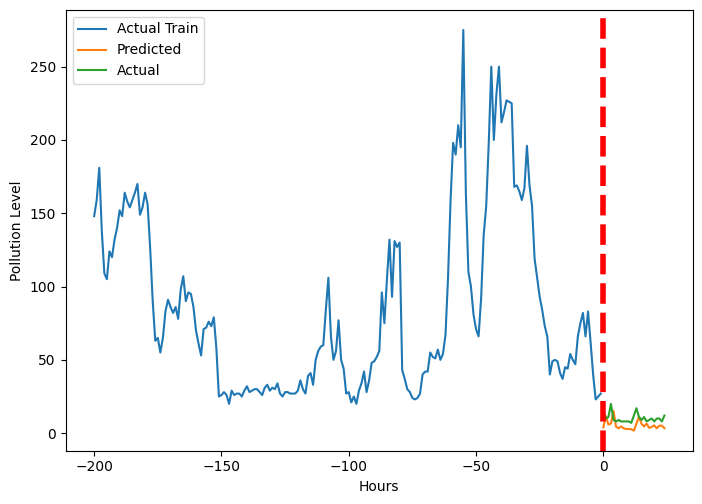

In [ ]:
idx = 24

df_train_sub = df_normalized.tail(dict_args['window_size'] + idx + 1).head(dict_args['window_size'])
predict_date = df_train_sub.tail(1).index.tolist()[0]
dict_args['predict_date'] = predict_date
print('predict_date: ', predict_date)
X_train, y_train, X_test, y_test = split_data(df_normalized, dict_args)
# (43785, 1, 8) (43785, 1) (13, 1, 8) (13, 1)

# Train Set 변환: 3D array -> 2D array; Inverse Transform
X_train = X_train.reshape((X_train.shape[0], X_train.shape[2]))
inv_train = np.concatenate((y_train, X_train[:, 1:]), axis=1)    # (43785 * 1) + (43785 * 7)
inv_train = scaler.inverse_transform(inv_train)
inv_train = inv_train[:,0]   # scaler는 2D array (43785 * 8)

# Test Set 변환: 3D array -> 2D array; Inverse Transform
'''
model_instance, filename = LSTM_MODEL(X_train, y_train,  X_test, y_test, valid_ratio=0.2)
model_instance.fit(X_train, y_train)
'''

print('학습된 모델 파일 읽습니다.')
model_instance = tensorflow.keras.models.load_model('./model/model_checkpoint.h5')
yhat = model_instance.predict(X_test)   # LSTM 모델은 3D array로 학습했기에 예측할때도 3D array로 들어감
X_test = X_test.reshape((X_test.shape[0], X_test.shape[2]))
inv_yhat = np.concatenate((yhat, X_test[:, 1:]), axis=1)    # (13 * 1) + (13 * 7)
inv_yhat = scaler.inverse_transform(inv_yhat)   # scaler는 2D array (13 * 8)
inv_yhat = inv_yhat[:,0]

y_test = y_test.reshape((len(y_test), 1))
inv_y = np.concatenate((y_test, X_test[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# 성능지표 결과
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
mae = mean_absolute_error(inv_y, inv_yhat)
print('Test MAE: %.3f' % mae)

# 예측값, 실제값 시각화
y_train = y_train.flatten()
fig, ax = plt.subplots(figsize=(7,5))
fig.tight_layout()

print(inv_train[:200])
print(inv_yhat)
print(inv_y)

# Train 기간 + Test 기간 한번에 그래프로 보기
ax.plot(list(range(-200,0)), inv_train[:200], label='Actual Train')
ax.plot(list(range(0,25)), inv_yhat, label='Predicted')
ax.plot(list(range(0,25)), inv_y, label='Actual')
ax.axvline(0, linewidth=4, linestyle='--', color='r')

# 따로 Test 기간 분리해서 그래프 비교
# plt.plot(inv_yhat[:200], label='Predicted')
# plt.plot(inv_y[:200], label='Actual')

ax.set_xlabel('Hours')
ax.set_ylabel('Pollution Level')
ax.legend()
fig.savefig('./model/' + 'result' + '_' + str(idx) + '.jpg')
